# SDFusion: Text-guided Generation (txt2shape)

### TODO: add sample results or teaser images

In [6]:
# first set up which gpu to use
import os
gpu_ids = 0
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_ids}"

In [7]:
# import libraries
import numpy as np
from IPython.display import Image as ipy_image
from IPython.display import display
from termcolor import colored, cprint

import torch
print(torch.cuda.is_available())
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
import torchvision.utils as vutils

from models.base_model import create_model
from utils.util_3d import render_sdf, render_mesh, sdf_to_mesh, save_mesh_as_gif

%load_ext autoreload
%autoreload 2

True
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# options for the model. please check `utils/demo_util.py` for more details
from utils.demo_util import SDFusionText2ShapeOpt

seed = 2023
opt = SDFusionText2ShapeOpt(gpu_ids=gpu_ids, seed=seed)
device = opt.device

[*] SDFusionText2ShapeOption initialized.


In [9]:
# enable proxy for huggingface

import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [10]:
# initialize SDFusion model
# ckpt_path = 'saved_ckpt/sdfusion-txt2shape.pth'
# ckpt_path = '/root/autodl-tmp/SDFusion/logs_home/continue-2024-04-05T17-15-19-sdfusion-txt2shape-text2shape-all-LR1e-5-clean-code/ckpt/df_steps-latest.pth'
# vqvae_path = '/root/autodl-tmp/SDFusion/logs_home/continue-2024-03-27T11-26-32-vqvae-snet-all-res64-LR1e-4-T0.2-release/ckpt/vqvae_epoch-best.pth'

ckpt_path = '/root/autodl-tmp/SDFusion/logs_home/continue-2024-04-19T21-55-32-sdfusion-txt2shape-text2shape-all-LR1e-5-clean-code/ckpt/df_steps-latest.pth'
vqvae_path = '/root/autodl-tmp/SDFusion/logs_home/continue-2024-04-19T14-51-01-vqvae-snet-all-res64-LR1e-5-T0.2-release/ckpt/vqvae_epoch-best.pth'
opt.init_model_args(ckpt_path=ckpt_path, vq_ckpt_path=vqvae_path)

SDFusion = create_model(opt)
cprint(f'[*] "{SDFusion.name()}" loaded.', 'cyan')

Working with z of shape (1, 3, 16, 16, 16) = 12288 dimensions.
[*] VQVAE: weight successfully load from: /root/autodl-tmp/SDFusion/logs_home/continue-2024-04-19T14-51-01-vqvae-snet-all-res64-LR1e-5-T0.2-release/ckpt/vqvae_epoch-best.pth
[*] weight successfully load from: /root/autodl-tmp/SDFusion/logs_home/continue-2024-04-19T21-55-32-sdfusion-txt2shape-text2shape-all-LR1e-5-clean-code/ckpt/df_steps-latest.pth
[*] setting ddim_steps=100
[*] Model has been created: SDFusion-Text2Shape-Model
[*] "SDFusion-Text2Shape-Model" loaded.


## SDFusion: text-guided generation (txt2shape)

Data shape for DDIM sampling is (9, 3, 16, 16, 16), eta 0.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|██████████| 100/100 [00:50<00:00,  1.96it/s]


Input: "bidirectional bending fold based soft actuator"


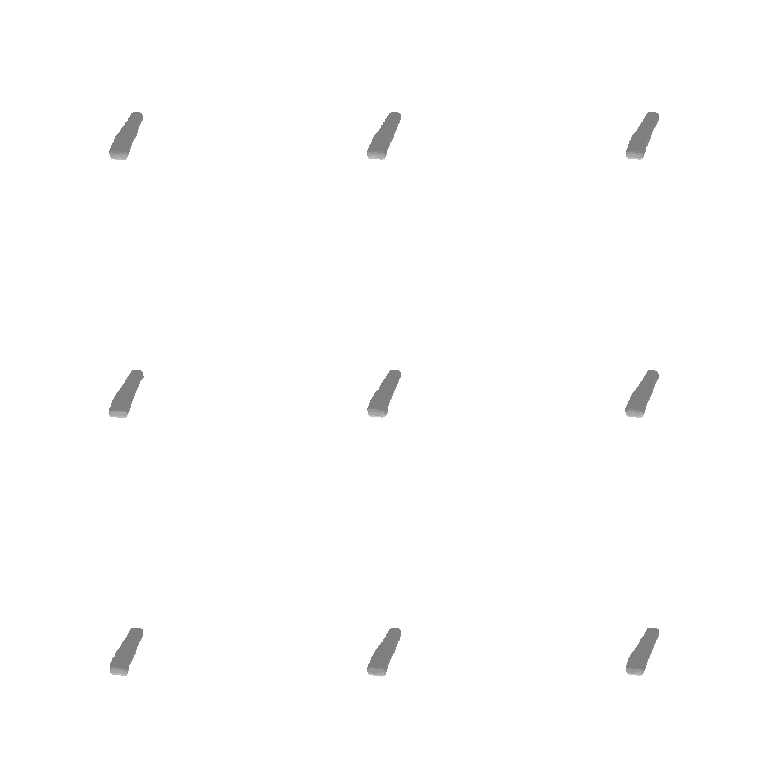

In [89]:
# txt2shape
out_dir = 'demo_results'
if not os.path.exists(out_dir): os.makedirs(out_dir)

# change the input text here to generate different chairs/tables!
input_txt = "bidirectional bending fold based soft actuator"

ngen = 9  # number of generated shapes
ddim_steps = 100
ddim_eta = 0.
uc_scale = 3.

sdf_gen = SDFusion.txt2shape(input_txt=input_txt, ngen=ngen, ddim_steps=ddim_steps, ddim_eta=ddim_eta, uc_scale=uc_scale)

mesh_gen = sdf_to_mesh(sdf_gen)

# vis as gif
gen_name = f'{out_dir}/txt2shape-{input_txt}.gif'
save_mesh_as_gif(SDFusion.renderer, mesh_gen, nrow=3, out_name=gen_name)

print(f'Input: "{input_txt}"')
for name in [gen_name]:
    display(ipy_image(name))

In [67]:
from pytorch3d.io import save_obj
# save mesh as obj
obj_name = f'/root/autodl-tmp/SDFusion/tmp/{input_txt}.obj'

save_obj(obj_name, mesh_gen.verts_list()[0], mesh_gen.faces_list()[0])

In [75]:
from pytorch3d.io import save_obj

for i in range(ngen):
    obj_name = f'/root/autodl-tmp/SDFusion/tmp/{input_txt}_{i}.obj'
    save_obj(obj_name, mesh_gen.verts_list()[i], mesh_gen.faces_list()[i])